# 2CSSID Workshop02. Data preparation & Model evaluation

<p style='text-align: right;font-style: italic; color: red;'>Designed by: Mr. Abdelkrime Aries</p>


In [2349]:
# Activate the lines to install unfound modules
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install imblearn

In [2350]:
import numpy  as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.26.2', '2.2.2', '3.9.2')

In [2351]:
import sqlite3
from imblearn.under_sampling import ClusterCentroids, TomekLinks
from imblearn.over_sampling import SMOTE

In [2352]:
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree         import DecisionTreeClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.ensemble     import RandomForestClassifier
from sklearn.metrics      import accuracy_score
from sklearn.metrics      import f1_score
import timeit

In [2353]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## 1. Business understanding

1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF) with softmax function.
    - ...
1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF, Other) with softmax function.
    - ...
1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF) with sigmoid function.
    - ...
1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF, Other) with sigmoid function.
    - ...
1. Two models, one for binary classification for failure yes/no. In case of failure, we train a second model to detect the
type similar to that of first solution.
    - ...
1. the same thing, but the second model is similar to that of the third solution.
    - ...

## 2. Data understanding

### 2.1. Collecting initial data

In [2354]:
# Step 1: Read the CSV file

csv_file_path = "data/ai4i2020a.csv"
df_csv = pd.read_csv(csv_file_path, delimiter=",")

print("CSV Data Preview:")
df_csv.head()

CSV Data Preview:


,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M0000A,M,NaN,NaN,1551.0,NaN,0.0,0,NOT
1,M14860,M,24.95,35.45,1551.0,42.8,0.0,0,NOT
2,L47181,L,25.05,35.55,1408.0,46.3,3.0,0,NOT
3,L47182,L,24.95,35.35,1498.0,49.4,5.0,0,NOT
4,L47183,L,25.05,35.45,1433.0,39.5,7.0,0,NOT


In [2355]:
# Step 2: Read the SQLite database

sqlite_db_path = "data/ai4i2020b.sqlite"

# Establish a connection to the SQLite database
conn = sqlite3.connect(sqlite_db_path)
query = "SELECT * FROM failure"
df_sqlite = pd.read_sql_query(query, conn).replace('', pd.NA)

# Close the database connection
conn.close()

print("\nSQLite Data Preview:")
df_sqlite.head()


SQLite Data Preview:


,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
0,M19859,303.7,312.9,1532,41.3,32,0,0,0,0,0,0
1,L52180,303.7,312.8,1832,23.6,35,0,0,0,0,0,0
2,M19861,303.6,312.7,2174,17.6,37,0,0,0,0,0,0
3,L52182,303.7,312.8,1627,31.7,40,0,0,0,0,0,0
4,L52183,303.7,312.8,1437,51.3,42,0,0,0,0,0,0


### 2.2. Describing data

In [2356]:
# Step 1: Show column info for both datasets

print("CSV Dataset Info:")
df_csv.info()

CSV Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               5983 non-null   object 
 1   Type                     5983 non-null   object 
 2   Air temperature [C]      5972 non-null   float64
 3   Process temperature [C]  5978 non-null   float64
 4   Rotational speed [rpm]   5978 non-null   float64
 5   Torque [Nm]              5982 non-null   float64
 6   Tool wear [min]          5980 non-null   float64
 7   Machine failure          5983 non-null   int64  
 8   Failure type             5983 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 420.8+ KB


In [2357]:
print("\nSQLite Dataset Info:")
df_sqlite.info()


SQLite Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    5019 non-null   object 
 1   Air_Temperature_K     5019 non-null   float64
 2   ProcessTemperature_K  5014 non-null   object 
 3   Rotational_speed      5016 non-null   object 
 4   Torque                5013 non-null   object 
 5   Tool_wear             5017 non-null   object 
 6   Failure               5019 non-null   int64  
 7   TWF                   5019 non-null   int64  
 8   HDF                   5019 non-null   int64  
 9   PWF                   5019 non-null   int64  
 10  OSF                   5019 non-null   int64  
 11  RNF                   5019 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 470.7+ KB


In [2358]:
# Step 2: Fix numerical values if not properly detected

df_csv["Rotational speed [rpm]"] = df_csv["Rotational speed [rpm]"].astype("Int64")
df_csv["Tool wear [min]"] = df_csv["Tool wear [min]"].astype("Int64")

df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               5983 non-null   object 
 1   Type                     5983 non-null   object 
 2   Air temperature [C]      5972 non-null   float64
 3   Process temperature [C]  5978 non-null   float64
 4   Rotational speed [rpm]   5978 non-null   Int64  
 5   Torque [Nm]              5982 non-null   float64
 6   Tool wear [min]          5980 non-null   Int64  
 7   Machine failure          5983 non-null   int64  
 8   Failure type             5983 non-null   object 
dtypes: Int64(2), float64(3), int64(1), object(3)
memory usage: 432.5+ KB


In [2359]:
df_sqlite["ProcessTemperature_K"] = df_sqlite["ProcessTemperature_K"].astype("Float64")
df_sqlite["Rotational_speed"] = df_sqlite["Rotational_speed"].astype("Int64")
df_sqlite["Torque"] = df_sqlite["Torque"].astype("Float64")
df_sqlite["Tool_wear"] = df_sqlite["Tool_wear"].astype("Int64")

df_sqlite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    5019 non-null   object 
 1   Air_Temperature_K     5019 non-null   float64
 2   ProcessTemperature_K  5014 non-null   Float64
 3   Rotational_speed      5016 non-null   Int64  
 4   Torque                5013 non-null   Float64
 5   Tool_wear             5017 non-null   Int64  
 6   Failure               5019 non-null   int64  
 7   TWF                   5019 non-null   int64  
 8   HDF                   5019 non-null   int64  
 9   PWF                   5019 non-null   int64  
 10  OSF                   5019 non-null   int64  
 11  RNF                   5019 non-null   int64  
dtypes: Float64(2), Int64(2), float64(1), int64(6), object(1)
memory usage: 490.3+ KB


In [2360]:
# Step 3: Describe both datasets

print("\nCSV Dataset Description:")
df_csv.describe()

print("\nSQLite Dataset Description:")
df_sqlite.describe()


CSV Dataset Description:

SQLite Dataset Description:


,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
count,5019.000000,5014.0,5016.0,5013.0,5017.0,5019.000000,5019.000000,5019.000000,5019.000000,5019.000000,5019.000000
mean,299.188643,309.552333,1535.59051,40.164692,107.365358,0.024308,0.005579,0.001793,0.009364,0.012154,0.002391
std,16.336889,16.388577,173.434366,10.006983,63.381024,0.154018,0.074490,0.042312,0.096325,0.109583,0.048843
min,24.850000,35.55,1181.0,9.7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,298.700000,309.6,1423.0,33.3,53.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,300.300000,310.6,1501.0,40.2,107.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,301.100000,311.5,1609.0,46.8,162.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,304.500000,313.8,2710.0,76.6,253.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [2361]:
# Step 4: Describe the CSV dataset where "Type" == "L"

df_csv[df_csv["Type"] == "L"].describe()

,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
count,3588.000000,3594.000000,3593.0,3595.000000,3594.0,3595.000000
mean,27.171433,36.767028,1541.608127,39.894214,109.676683,0.043672
std,2.266254,1.648043,186.036898,10.025461,64.124618,0.204392
min,22.150000,32.550000,1192.0,3.800000,0.0,0.000000
25%,25.150000,35.450000,1422.0,33.150000,55.0,0.000000
50%,27.150000,36.650000,1504.0,40.000000,111.0,0.000000
75%,29.150000,37.950000,1614.0,46.800000,164.0,0.000000
max,31.350000,40.650000,2886.0,71.600000,251.0,1.000000


In [2362]:
# Step 5: Show categories of non-unique categorical features
# Find non-unique categorical features

categorical_columns = df_csv.select_dtypes(include=['object', 'category']).columns
print("\nUnique Categories in CSV Categorical Features:")
for col in categorical_columns:
    unique_categories = df_csv[col].unique()
    print(f"{col}: {unique_categories}")
    
categorical_columns = df_sqlite.select_dtypes(include=['object', 'category']).columns
print("\nUnique Categories in SQLite Categorical Features:")
for col in categorical_columns:
    unique_categories = df_sqlite[col].unique()
    print(f"{col}: {unique_categories}")


Unique Categories in CSV Categorical Features:
Product ID: ['M0000A' 'M14860' 'L47181' ... 'M20857' 'M20858' 'M20859']
Type: ['M' 'L' 'H']
Failure type: ['NOT' 'PWF' 'TWF' 'OSF' 'RNF' 'OTHER' 'HDF']

Unique Categories in SQLite Categorical Features:
ID: ['M19859' 'L52180' 'M19861' ... 'L51822' 'L51823' 'L51909']


### 2.3. Exploring data

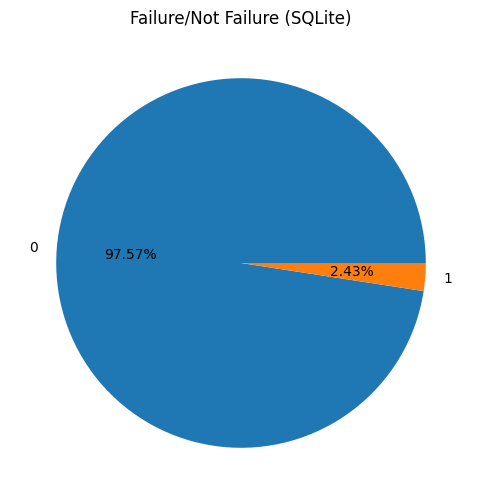

In [2363]:
# Step 1: Plot a pie chart for binary relation failure/not

def plot_pie_chart(data, column, title):
    labels, counts = np.unique(data[column], return_counts=True)
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.2f%%')
    plt.title(title)
    plt.show()
    
plot_pie_chart(df_sqlite, "Failure", "Failure/Not Failure (SQLite)")

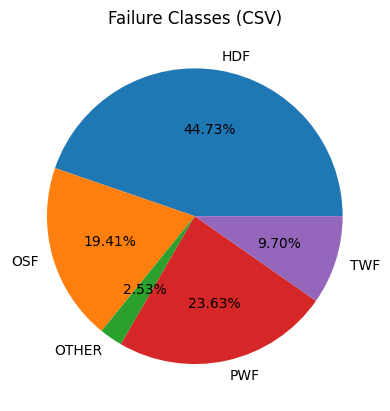

In [2364]:
# Step 2: Plot a pie chart for different failure classes

labels, counts = np.unique(df_csv[df_csv['Machine failure']==1]['Failure type'], return_counts=True)
plt.pie(counts, labels=labels, autopct='%1.2f%%')
plt.title("Failure Classes (CSV)")
plt.show()


Pie Chart: Failure Classes (SQLite)


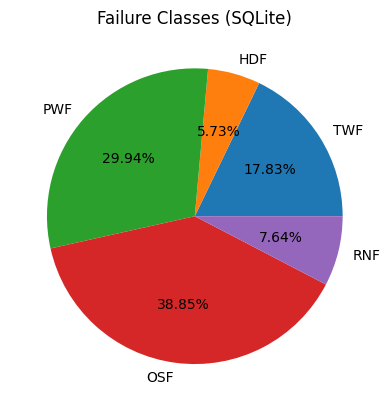

In [2365]:
failure_columns = ["TWF", "HDF", "PWF", "OSF", "RNF"]

def plot_failure_classes(data, title):
    counts = data[failure_columns].sum()
    plt.pie(counts, labels=failure_columns, autopct='%1.2f%%')
    plt.title(title)
    plt.show()

print("Pie Chart: Failure Classes (SQLite)")
plot_failure_classes(df_sqlite, "Failure Classes (SQLite)")

Box Plot: Temperature Features (CSV)


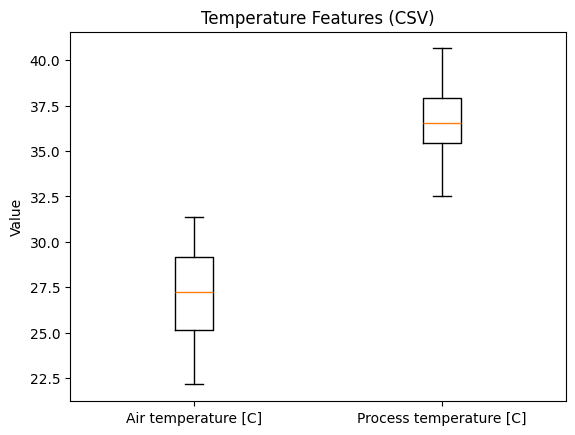

Box Plot: Temperature Features (SQLite)


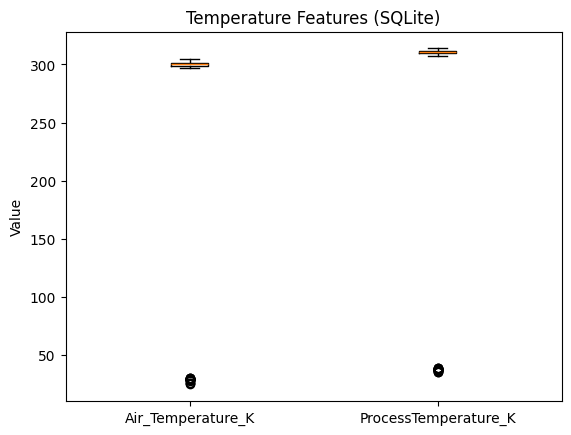

In [2366]:
# Step 3: Draw box plots for temperature features

temperature_features_csv = ["Air temperature [C]", "Process temperature [C]"]
temperature_features_sqlite = ["Air_Temperature_K", "ProcessTemperature_K"]

def plot_box_plots(data, title, temperature_features):
    non_null_data = data[temperature_features].dropna()
    plt.boxplot(non_null_data, tick_labels=temperature_features)
    plt.title(title)
    plt.ylabel("Value")
    plt.show()


print("Box Plot: Temperature Features (CSV)")
plot_box_plots(df_csv, "Temperature Features (CSV)", temperature_features_csv)


print("Box Plot: Temperature Features (SQLite)")
plot_box_plots(df_sqlite, "Temperature Features (SQLite)", temperature_features_sqlite)


In [2367]:
# Detect and display outliers

outliers_sqlite = df_sqlite[(df_sqlite['Air_Temperature_K'] < 100) | (df_sqlite['ProcessTemperature_K'] < 100)]

print(f"\nOutliers in (SQLite):")
outliers_sqlite


Outliers in (SQLite):


,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
5001,L47249,25.75,35.85,1410,65.7,191,1,0,0,1,1,0
5002,M16184,25.65,36.95,1243,74.5,194,1,0,0,1,1,0
5003,L48676,24.85,35.55,1268,69.4,189,1,0,0,1,1,0
5004,L50791,28.55,37.75,1405,46.4,207,1,1,0,0,0,1
5005,L51034,29.25,37.85,1338,67.6,194,1,0,0,1,1,0
5006,L51123,29.15,38.25,1333,66.7,205,1,0,0,1,1,0
5007,L51434,29.45,37.85,1284,68.0,114,1,0,1,1,0,0
5008,M19202,28.55,36.65,1284,68.2,111,1,0,1,1,0,0
5009,L51550,28.85,36.75,1308,57.6,197,1,0,1,0,1,0
5010,L51563,28.55,36.35,1298,65.5,229,1,0,1,0,1,0


Pie Chart: Product Type (CSV)


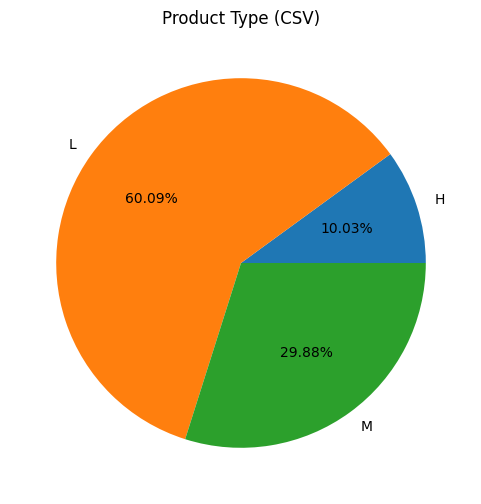

In [2368]:
# Step 4: Plot a pie chart of "Type"

print("Pie Chart: Product Type (CSV)")
plot_pie_chart(df_csv, "Type", "Product Type (CSV)")

In [2369]:
# Step 5: Apply PCA for dimensionality reduction

pca_features_sqlite = ["Air_Temperature_K", "ProcessTemperature_K", "Rotational_speed", "Torque", "Tool_wear"]
pca_features_csv = ["Air temperature [C]", "Process temperature [C]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]

def apply_pca(data, pca_features):
    data_clean = data[pca_features].dropna()
    pca = PCA(2)
    principal_components = pca.fit_transform(data_clean)
    return pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

pca_csv = apply_pca(df_csv, pca_features_csv)
pca_sqlite = apply_pca(df_sqlite, pca_features_sqlite)

PCA Distribution (CSV)


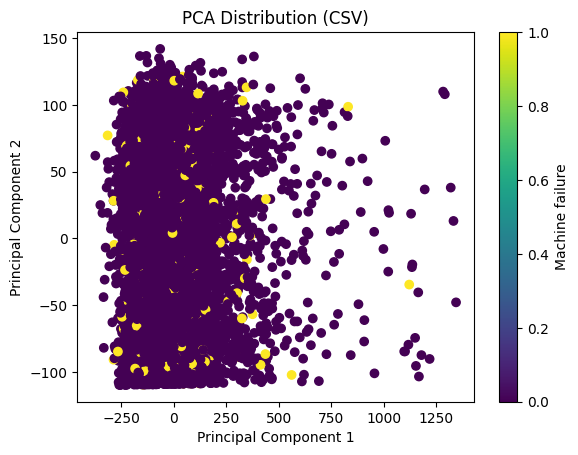

PCA Distribution (SQLite)


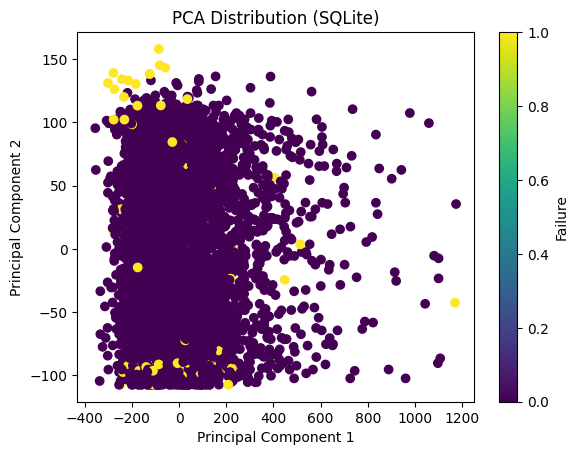

In [2370]:
# Step 6: Plot samples' distribution

def plot_pca_distribution(pca_data, data, title, column):
    plt.scatter(pca_data["PC1"], pca_data["PC2"], c=data[column].iloc[:len(pca_data)])
    plt.colorbar(label=column)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(title)
    plt.show()

print("PCA Distribution (CSV)")
plot_pca_distribution(pca_csv, df_csv, "PCA Distribution (CSV)", "Machine failure")

print("PCA Distribution (SQLite)")
plot_pca_distribution(pca_sqlite, df_sqlite, "PCA Distribution (SQLite)", "Failure")

### 2.4. Verifying data quality

In [2371]:
# Step 1: Samples with at least one omitted value
omitted_values_csv = df_csv[df_csv.isnull().any(axis=1)]
print("Samples with omitted values in CSV:")
omitted_values_csv

Samples with omitted values in CSV:


,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M0000A,M,NaN,NaN,1551,NaN,0,0,NOT
1435,H30850,H,25.65,NaN,1510,44.2,35,0,NOT
2786,L49968,L,NaN,36.45,1326,52.4,57,0,NOT
2791,L49973,L,NaN,36.45,1597,31.8,73,0,NOT
2796,L49978,L,NaN,36.45,1568,39.6,85,0,NOT
2797,L49979,L,NaN,36.45,1404,44.6,87,0,NOT
2820,L50002,L,NaN,36.45,1593,38.1,140,0,NOT
5723,M20599,M,NaN,38.55,<NA>,31.4,2,0,NOT
5724,M20600,M,NaN,38.55,<NA>,38.3,5,0,NOT
5725,M20601,M,NaN,38.55,<NA>,40.5,8,0,NOT


In [2372]:
omitted_values_sqlite = df_sqlite[df_sqlite.isnull().any(axis=1)]
print("Samples with omitted values in SQLite:")
omitted_values_sqlite

Samples with omitted values in SQLite:


,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
740,M20599,302.2,<NA>,1653,<NA>,2,0,0,0,0,0,0
741,M20600,302.3,<NA>,1535,<NA>,5,0,0,0,0,0,0
742,M20601,302.3,<NA>,1483,40.5,<NA>,0,0,0,0,0,0
743,L52922,302.3,<NA>,1414,47.0,<NA>,0,0,0,0,0,0
744,M20603,302.2,311.6,<NA>,<NA>,13,0,0,0,0,0,0
745,H35158,302.2,311.5,<NA>,<NA>,16,0,0,0,0,0,0
746,L52925,302.1,311.5,<NA>,<NA>,21,0,0,0,0,0,0
942,L53121,300.6,<NA>,1438,<NA>,78,1,0,0,0,0,0


In [2373]:
# Step 2: Samples which do not have a failure, but have a failure type
contradictions_csv = df_csv[(df_csv["Machine failure"] == 0) & (df_csv["Failure type"] != "NOT")]
print("Contradictions in CSV dataset:")
contradictions_csv

Contradictions in CSV dataset:


,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
1221,M16081,M,23.85,35.15,1399,46.4,132,0,RNF
1302,L48482,L,25.45,36.65,1505,45.7,144,0,RNF
1746,H31162,H,25.25,34.55,1626,31.1,166,0,RNF
2070,L49252,L,26.45,36.35,1570,35.5,189,0,RNF
2557,L49739,L,26.15,35.85,1447,50.4,140,0,RNF
3063,M17925,M,26.95,36.05,1687,27.7,95,0,RNF
3450,H32866,H,28.45,37.35,1602,32.3,2,0,RNF
5455,L52651,L,29.55,39.15,1346,61.2,170,0,RNF
5473,L52669,L,29.45,38.95,1499,35.0,215,0,RNF
5479,H34909,H,29.75,39.35,1357,55.0,12,0,RNF


In [2374]:
failure_type_columns = ["TWF", "HDF", "PWF", "OSF", "RNF"]
contradictions_sqlite = df_sqlite[
    (df_sqlite["Failure"] == 0) & (df_sqlite[failure_type_columns].sum(axis=1) > 0)
]
print("Contradictions in SQLite dataset:")
contradictions_sqlite

Contradictions in SQLite dataset:


,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
472,L52651,302.7,312.3,1346,61.2,170,0,0,0,0,0,1
490,L52669,302.6,312.1,1499,35.0,215,0,0,0,0,0,1
496,H34909,302.9,312.5,1357,55.0,12,0,0,0,0,0,1
510,L52689,302.8,312.2,1509,36.5,52,0,0,0,0,0,1
554,L52733,302.5,311.9,1306,59.7,172,0,0,0,0,0,1
640,L52819,302.6,312.1,1668,28.7,180,0,0,0,0,0,1
1092,L53271,300.9,310.7,1412,57.5,16,0,0,0,0,0,1
1914,L54093,300.8,311.2,1481,38.5,181,0,0,0,0,0,1
1961,L54140,300.7,311.0,1413,52.0,91,0,0,0,0,0,1
2489,L54668,300.3,311.7,1545,43.5,160,0,0,0,0,0,1


## 3. Data preparation

### 3.1. Selecting data

Do we need these features: "Product ID" and "Machine failure"? Why?
- "Product ID"?
    - No
    - The Product ID is essentially an identifier, not a feature that directly contributes to the prediction of machine failures or failure modes. While it contains some information (e.g., Type), that information is already represented explicitly in the Type column, making Product ID redundant for modeling purposes.
- "Machine failure"? 
    - Yes
    - This feature is essential for:
        - Understanding and modeling failure types: It allows us to focus on rows where failures occurred.
        - Hierarchical modeling strategies: If we decide to build a two-stage model, Machine failure can be used in the first stage to predict if a failure occurred at all.

### 3.2. Constructing new data 

In [2375]:
# Step 1: Transform Celsius into Kelvin for temperature

df_csv["Air temperature [K]"] = df_csv["Air temperature [C]"] + 273.15
df_csv["Process temperature [K]"] = df_csv["Process temperature [C]"] + 273.15

df_csv.head()

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type,Air temperature [K],Process temperature [K]
0,M0000A,M,NaN,NaN,1551,NaN,0,0,NOT,NaN,NaN
1,M14860,M,24.95,35.45,1551,42.8,0,0,NOT,298.1,308.6
2,L47181,L,25.05,35.55,1408,46.3,3,0,NOT,298.2,308.7
3,L47182,L,24.95,35.35,1498,49.4,5,0,NOT,298.1,308.5
4,L47183,L,25.05,35.45,1433,39.5,7,0,NOT,298.2,308.6


In [2376]:
# Step 2: Transform Failure types into one categorical column and delete original columns

failure_columns_sqlite = ["TWF", "HDF", "PWF", "OSF", "RNF"]

df_sqlite["Failure type"] = df_sqlite[failure_columns_sqlite].idxmax(axis=1).where(df_sqlite[failure_columns_sqlite].sum(axis=1) > 0, "NOT")

# Drop the original failure type columns
df_sqlite.drop(columns=failure_columns_sqlite, inplace=True)

In [2377]:
# Step 3: Add another column for the failure type "OTHER"

df_sqlite["OTHER"] = (df_sqlite["Failure"] == 1) & (df_sqlite["Failure type"] == "NOT")

df_sqlite.head()

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,Failure type,OTHER
0,M19859,303.7,312.9,1532,41.3,32,0,NOT,False
1,L52180,303.7,312.8,1832,23.6,35,0,NOT,False
2,M19861,303.6,312.7,2174,17.6,37,0,NOT,False
3,L52182,303.7,312.8,1627,31.7,40,0,NOT,False
4,L52183,303.7,312.8,1437,51.3,42,0,NOT,False


In [2378]:
# Step 4: If "Type" does not exist, infer it from "Product ID"

df_csv["Type"] = df_csv["Type"].fillna(df_csv["Product ID"].str[0])

df_csv.head()

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type,Air temperature [K],Process temperature [K]
0,M0000A,M,NaN,NaN,1551,NaN,0,0,NOT,NaN,NaN
1,M14860,M,24.95,35.45,1551,42.8,0,0,NOT,298.1,308.6
2,L47181,L,25.05,35.55,1408,46.3,3,0,NOT,298.2,308.7
3,L47182,L,24.95,35.35,1498,49.4,5,0,NOT,298.1,308.5
4,L47183,L,25.05,35.45,1433,39.5,7,0,NOT,298.2,308.6


In [2379]:
# Step 5: Transform "Type" into OneHot representation

type_onehot_csv = pd.get_dummies(df_csv["Type"], prefix="Type")
df_csv = pd.concat([df_csv, type_onehot_csv], axis=1)

df_csv.head()

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type,Air temperature [K],Process temperature [K],Type_H,Type_L,Type_M
0,M0000A,M,NaN,NaN,1551,NaN,0,0,NOT,NaN,NaN,False,False,True
1,M14860,M,24.95,35.45,1551,42.8,0,0,NOT,298.1,308.6,False,False,True
2,L47181,L,25.05,35.55,1408,46.3,3,0,NOT,298.2,308.7,False,True,False
3,L47182,L,24.95,35.35,1498,49.4,5,0,NOT,298.1,308.5,False,True,False
4,L47183,L,25.05,35.45,1433,39.5,7,0,NOT,298.2,308.6,False,True,False


### 3.3. Integrating data

In [2380]:
# Step 1: Rename columns in the SQLite dataset to match CSV schema

df_sqlite.rename(columns={
    "ID": "Product ID",
    "Air_Temperature_K": "Air temperature [K]",
    "ProcessTemperature_K": "Process temperature [K]",
    "Rotational_speed": "Rotational speed [rpm]",
    "Torque": "Torque [Nm]",
    "Tool_wear": "Tool wear [min]",
    "Failure": "Machine failure"
}, inplace=True)


In [2381]:
# Step 2: Delete unshared columns

common_columns = list(set(df_csv.columns).intersection(set(df_sqlite.columns)))

df_csv = df_csv[common_columns]
df_sqlite = df_sqlite[common_columns]

df_csv

,Air temperature [K],Tool wear [min],Failure type,Product ID,Process temperature [K],Rotational speed [rpm],Machine failure,Torque [Nm]
0,NaN,0,NOT,M0000A,NaN,1551,0,NaN
1,298.1,0,NOT,M14860,308.6,1551,0,42.8
2,298.2,3,NOT,L47181,308.7,1408,0,46.3
3,298.1,5,NOT,L47182,308.5,1498,0,49.4
4,298.2,7,NOT,L47183,308.6,1433,0,39.5
...,...,...,...,...,...,...,...,...
5978,300.6,223,NOT,L53175,310.3,1920,0,22.3
5979,300.5,225,NOT,M20856,310.2,1386,0,48.2
5980,300.5,228,NOT,M20857,310.2,1571,0,34.6
5981,300.4,231,NOT,M20858,310.2,1613,0,36.9


In [2382]:
df_sqlite

,Air temperature [K],Tool wear [min],Failure type,Product ID,Process temperature [K],Rotational speed [rpm],Machine failure,Torque [Nm]
0,303.70,32,NOT,M19859,312.9,1532,0,41.3
1,303.70,35,NOT,L52180,312.8,1832,0,23.6
2,303.60,37,NOT,M19861,312.7,2174,0,17.6
3,303.70,40,NOT,L52182,312.8,1627,0,31.7
4,303.70,42,NOT,L52183,312.8,1437,0,51.3
...,...,...,...,...,...,...,...,...
5014,30.05,228,HDF,L51823,38.25,1324,1,54.2
5015,30.25,215,HDF,L51909,38.65,1306,1,61.0
5016,29.65,234,PWF,M20254,39.15,1262,1,70.5
5017,29.45,253,TWF,M20261,39.15,1454,1,54.8


In [2383]:
# Step 3: Merge the two tables into one

df = pd.concat([df_csv, df_sqlite], ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11002 entries, 0 to 11001
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10991 non-null  float64
 1   Tool wear [min]          10997 non-null  Int64  
 2   Failure type             11002 non-null  object 
 3   Product ID               11002 non-null  object 
 4   Process temperature [K]  10992 non-null  Float64
 5   Rotational speed [rpm]   10994 non-null  Int64  
 6   Machine failure          11002 non-null  int64  
 7   Torque [Nm]              10995 non-null  Float64
dtypes: Float64(2), Int64(2), float64(1), int64(1), object(2)
memory usage: 730.7+ KB


### 3.4. Cleaning data

In [2384]:
# Step 1: Delete inconsistent samples
df = df[~((df["Machine failure"] == 0) & (df["Failure type"] != "NOT"))]

df

,Air temperature [K],Tool wear [min],Failure type,Product ID,Process temperature [K],Rotational speed [rpm],Machine failure,Torque [Nm]
0,NaN,0,NOT,M0000A,<NA>,1551,0,<NA>
1,298.10,0,NOT,M14860,308.6,1551,0,42.8
2,298.20,3,NOT,L47181,308.7,1408,0,46.3
3,298.10,5,NOT,L47182,308.5,1498,0,49.4
4,298.20,7,NOT,L47183,308.6,1433,0,39.5
...,...,...,...,...,...,...,...,...
10997,30.05,228,HDF,L51823,38.25,1324,1,54.2
10998,30.25,215,HDF,L51909,38.65,1306,1,61.0
10999,29.65,234,PWF,M20254,39.15,1262,1,70.5
11000,29.45,253,TWF,M20261,39.15,1454,1,54.8


In [2385]:
# Step 2: Find duplicate samples using "Product ID"

duplicates = df[df.duplicated(subset=["Product ID"], keep=False)]
print("Duplicate samples:\n", duplicates)

Duplicate samples:
        Air temperature [K]  Tool wear [min] Failure type Product ID  \
4985                303.70               32          NOT     M19859   
4986                303.70               35          NOT     L52180   
4987                303.60               37          NOT     M19861   
4988                303.70               40          NOT     L52182   
4989                303.70               42          NOT     L52183   
...                    ...              ...          ...        ...   
6982                300.40              231          NOT     M20858   
6983                300.40              234          TWF     M20859   
10999                29.65              234          PWF     M20254   
11000                29.45              253          TWF     M20261   
11001                27.55              208          TWF     H35323   

       Process temperature [K]  Rotational speed [rpm]  Machine failure  \
4985                     312.9                    15

In [2386]:
# Step 3: Replace all missing values from the same product

df.update(df.groupby('Product ID').ffill())
df.update(df.groupby('Product ID').bfill())

df

,Air temperature [K],Tool wear [min],Failure type,Product ID,Process temperature [K],Rotational speed [rpm],Machine failure,Torque [Nm]
0,NaN,0,NOT,M0000A,<NA>,1551,0,<NA>
1,298.10,0,NOT,M14860,308.6,1551,0,42.8
2,298.20,3,NOT,L47181,308.7,1408,0,46.3
3,298.10,5,NOT,L47182,308.5,1498,0,49.4
4,298.20,7,NOT,L47183,308.6,1433,0,39.5
...,...,...,...,...,...,...,...,...
10997,30.05,228,HDF,L51823,38.25,1324,1,54.2
10998,30.25,215,HDF,L51909,38.65,1306,1,61.0
10999,29.65,234,PWF,M20254,39.15,1262,1,70.5
11000,29.45,253,TWF,M20261,39.15,1454,1,54.8


In [2387]:
# Step 4: Delete duplicates

df.drop_duplicates('Product ID', keep='last', inplace=True)

df

,Air temperature [K],Tool wear [min],Failure type,Product ID,Process temperature [K],Rotational speed [rpm],Machine failure,Torque [Nm]
0,NaN,0,NOT,M0000A,<NA>,1551,0,<NA>
1,298.10,0,NOT,M14860,308.6,1551,0,42.8
2,298.20,3,NOT,L47181,308.7,1408,0,46.3
3,298.10,5,NOT,L47182,308.5,1498,0,49.4
4,298.20,7,NOT,L47183,308.6,1433,0,39.5
...,...,...,...,...,...,...,...,...
10997,30.05,228,HDF,L51823,38.25,1324,1,54.2
10998,30.25,215,HDF,L51909,38.65,1306,1,61.0
10999,29.65,234,PWF,M20254,39.15,1262,1,70.5
11000,29.45,253,TWF,M20261,39.15,1454,1,54.8


In [2388]:
# Step 5: Create a "NOT" column for no failure

df["NOT"] = (df["Failure type"] == "NOT").astype(int)

df

,Air temperature [K],Tool wear [min],Failure type,Product ID,Process temperature [K],Rotational speed [rpm],Machine failure,Torque [Nm],NOT
0,NaN,0,NOT,M0000A,<NA>,1551,0,<NA>,1
1,298.10,0,NOT,M14860,308.6,1551,0,42.8,1
2,298.20,3,NOT,L47181,308.7,1408,0,46.3,1
3,298.10,5,NOT,L47182,308.5,1498,0,49.4,1
4,298.20,7,NOT,L47183,308.6,1433,0,39.5,1
...,...,...,...,...,...,...,...,...,...
10997,30.05,228,HDF,L51823,38.25,1324,1,54.2,0
10998,30.25,215,HDF,L51909,38.65,1306,1,61.0,0
10999,29.65,234,PWF,M20254,39.15,1262,1,70.5,0
11000,29.45,253,TWF,M20261,39.15,1454,1,54.8,0


In [2389]:
# Step 6: Delete "Product ID" and "Machine failure"

df = df.drop(columns=["Product ID", "Machine failure"])

df

,Air temperature [K],Tool wear [min],Failure type,Process temperature [K],Rotational speed [rpm],Torque [Nm],NOT
0,NaN,0,NOT,<NA>,1551,<NA>,1
1,298.10,0,NOT,308.6,1551,42.8,1
2,298.20,3,NOT,308.7,1408,46.3,1
3,298.10,5,NOT,308.5,1498,49.4,1
4,298.20,7,NOT,308.6,1433,39.5,1
...,...,...,...,...,...,...,...
10997,30.05,228,HDF,38.25,1324,54.2,0
10998,30.25,215,HDF,38.65,1306,61.0,0
10999,29.65,234,PWF,39.15,1262,70.5,0
11000,29.45,253,TWF,39.15,1454,54.8,0


In [2390]:
# Step 7: Delete rows with more than one missing value

df = df[df.isnull().sum(axis=1) <= 1]

df

,Air temperature [K],Tool wear [min],Failure type,Process temperature [K],Rotational speed [rpm],Torque [Nm],NOT
1,298.10,0,NOT,308.6,1551,42.8,1
2,298.20,3,NOT,308.7,1408,46.3,1
3,298.10,5,NOT,308.5,1498,49.4,1
4,298.20,7,NOT,308.6,1433,39.5,1
5,298.20,9,NOT,308.7,1408,40.0,1
...,...,...,...,...,...,...,...
10997,30.05,228,HDF,38.25,1324,54.2,0
10998,30.25,215,HDF,38.65,1306,61.0,0
10999,29.65,234,PWF,39.15,1262,70.5,0
11000,29.45,253,TWF,39.15,1454,54.8,0


In [2391]:
mn_rp = lambda x: x.fillna(x.mean())

for col in df.columns:
    if df[col].isnull().any():
        df.loc[:, col] = df.groupby("Failure type")[col].transform(mn_rp)

df

,Air temperature [K],Tool wear [min],Failure type,Process temperature [K],Rotational speed [rpm],Torque [Nm],NOT
1,298.10,0,NOT,308.6,1551,42.8,1
2,298.20,3,NOT,308.7,1408,46.3,1
3,298.10,5,NOT,308.5,1498,49.4,1
4,298.20,7,NOT,308.6,1433,39.5,1
5,298.20,9,NOT,308.7,1408,40.0,1
...,...,...,...,...,...,...,...
10997,30.05,228,HDF,38.25,1324,54.2,0
10998,30.25,215,HDF,38.65,1306,61.0,0
10999,29.65,234,PWF,39.15,1262,70.5,0
11000,29.45,253,TWF,39.15,1454,54.8,0


### 3.5. Formatting data and Constructing new data

In [2392]:
# Step 1: Put the classes at the end

class_columns = ["Failure type", "NOT"]
non_class_columns = [col for col in df.columns if col not in class_columns]
df = df[non_class_columns + class_columns]

In [2393]:
# Step 2: Split data into train (70%) and test (30%)

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Failure type"])

In [2394]:
# Step 3: Convert multi-label to multi-class

# Ensure DataFrames are independent copies
df = df.copy()
train_df = train_df.copy()
test_df = test_df.copy()

# Combine columns into a single class
df.loc[:, "Combined Class"] = df[class_columns].astype(str).agg("-".join, axis=1)
train_df.loc[:, "Combined Class"] = train_df[class_columns].astype(str).agg("-".join, axis=1)
test_df.loc[:, "Combined Class"] = test_df[class_columns].astype(str).agg("-".join, axis=1)

# Implement a revert function to split back into individual classes
def revert_combined_class(combined_class):
    return combined_class.split("-")

df

,Air temperature [K],Tool wear [min],Process temperature [K],Rotational speed [rpm],Torque [Nm],Failure type,NOT,Combined Class
1,298.10,0,308.6,1551,42.8,NOT,1,NOT-1
2,298.20,3,308.7,1408,46.3,NOT,1,NOT-1
3,298.10,5,308.5,1498,49.4,NOT,1,NOT-1
4,298.20,7,308.6,1433,39.5,NOT,1,NOT-1
5,298.20,9,308.7,1408,40.0,NOT,1,NOT-1
...,...,...,...,...,...,...,...,...
10997,30.05,228,38.25,1324,54.2,HDF,0,HDF-0
10998,30.25,215,38.65,1306,61.0,HDF,0,HDF-0
10999,29.65,234,39.15,1262,70.5,PWF,0,PWF-0
11000,29.45,253,39.15,1454,54.8,TWF,0,TWF-0


In [2395]:
# Step 4: Apply SMOTE for oversampling

# Filter classes with more than 10 samples
valid_classes = train_df["Combined Class"].value_counts()[train_df["Combined Class"].value_counts() > 10].index
train_df_filtered = train_df[train_df["Combined Class"].isin(valid_classes)]

# Separate features and labels
X_train = train_df_filtered.drop(columns=["Combined Class"])
y_train = train_df_filtered["Combined Class"]

# Convert 'Failure type' to numeric using LabelEncoder
le = LabelEncoder()
X_train['Failure type'] = le.fit_transform(X_train['Failure type'])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

In [2396]:
# Step 5: Apply under-sampling techniques

# a. ClusterCentroids
cluster_centroids = ClusterCentroids(random_state=42)
X_cc, y_cc = cluster_centroids.fit_resample(X_train_scaled, y_train)

# b. TomekLinks
tomek_links = TomekLinks()
X_tl, y_tl = tomek_links.fit_resample(X_train_scaled, y_train)

In [2397]:
# Step 6: Apply normalization (StandardScaler)

scaler = StandardScaler()

# No_sampling_normalized
X_train_norm = scaler.fit_transform(X_train)

# SMOTE_normalized
X_smote_norm = scaler.fit_transform(X_smote)

# ClusterCentroids_normalized
X_cc_norm = scaler.fit_transform(X_cc)

# TomekLinks_normalized
X_tl_norm = scaler.fit_transform(X_tl)

#Combine All Training Datasets
datasets = {
    "No_sampling": (X_train, y_train),
    "No_sampling_normalized": (X_train_norm, y_train),
    "SMOTE": (X_smote, y_smote),
    "SMOTE_normalized": (X_smote_norm, y_smote),
    "ClusterCentroids": (X_cc, y_cc),
    "ClusterCentroids_normalized": (X_cc_norm, y_cc),
    "TomekLinks": (X_tl, y_tl),
    "TomekLinks_normalized": (X_tl_norm, y_tl),
}

In [2398]:
# Step 7: Normalize Test Dataset

# Separate features and labels
X_test = test_df.drop(columns=["Combined Class"])
y_test = test_df["Combined Class"]
l = y_test.shape[0]

# Convert 'Failure type' to numeric using LabelEncoder
X_test['Failure type'] = le.fit_transform(X_test['Failure type'])

# Normalize test data
X_test_norm = scaler.fit_transform(X_test)

test_datasets = {
    "No_sampling": (X_test, y_test),
    "No_sampling_normalized": (X_test_norm, y_test),
}

## 4. Modeling and Evaluation

In [ ]:
# Define the models to use
models = {
    "Logistic Regression": LogisticRegression(solver="liblinear", penalty="l2"),
    "Gaussian Naive Bayes": GaussianNB(),
    "CART Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=50)
}

# Define datasets for training and testing
datasets = [
    ('plain', X_train, X_test, y_train, y_test),
    ('plain-norm', X_train_norm, X_test_norm, y_train, y_test),
    ('smote', X_smote, X_test, y_smote, y_test),
    ('smote-norm', X_smote_norm, X_test_norm, y_smote, y_test),
    ('cc', X_cc, X_test, y_cc, y_test),
    ('cc-norm', X_cc_norm, X_test_norm, y_cc, y_test),
    ('tl', X_tl, X_test, y_tl, y_test),
    ('tl-norm', X_tl_norm, X_test_norm, y_tl, y_test),
]

# Initialize a DataFrame to store the results
results = []

X_train = np.array(X_train)  # Convert to NumPy array without feature names
X_test = np.array(X_test)    # Convert to NumPy array without feature names

for dataset_name, X_train, X_test, y_train, y_test in datasets:
    X_train = np.array(X_train)  # Convert to NumPy array without feature names
    X_test = np.array(X_test)    # Convert to NumPy array without feature names
    
    for model_name, model in models.items():
        # Record start time for training
        start_train_time = timeit.default_timer()
        model.fit(X_train, y_train)
        train_time = timeit.default_timer() - start_train_time
        
        # Record start time for prediction (training accuracy)
        start_test_time = timeit.default_timer()
        train_preds = model.predict(X_train)
        train_time_predict = timeit.default_timer() - start_test_time
        
        # Calculate training accuracy
        train_accuracy = accuracy_score(y_train, train_preds)
        
        # Now, test on the test dataset (X_test and y_test)
        start_test_time = timeit.default_timer()
        test_preds = model.predict(X_test)  # Use NumPy array for prediction
        test_time = timeit.default_timer() - start_test_time
        
        # Calculate test accuracy
        test_accuracy = accuracy_score(y_test, test_preds)
        
        # Store results
        results.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "Train Time": train_time,
            "Test Time": test_time,
            "Train Accuracy": train_accuracy,
            "Test Accuracy": test_accuracy
        })
        
# Create a summary DataFrame of all results
results_df = pd.DataFrame(results)

# Display the summary table
results_df


,Model,Dataset,Train Time,Test Time,Train Accuracy,Test Accuracy
0,Logistic Regression,plain,0.130633,0.000814,0.999141,0.999332
1,Gaussian Naive Bayes,plain,0.009161,0.001168,1.000000,0.990651
2,CART Decision Tree,plain,0.009641,0.000821,1.000000,0.990651
3,Random Forest,plain,0.125684,0.005354,1.000000,0.999332
4,Logistic Regression,plain-norm,0.048690,0.000356,0.999714,0.999666
5,Gaussian Naive Bayes,plain-norm,0.007187,0.000638,1.000000,0.999666
6,CART Decision Tree,plain-norm,0.008111,0.000310,1.000000,0.999666
7,Random Forest,plain-norm,0.133334,0.005183,1.000000,0.999332
8,Logistic Regression,smote,0.308131,0.001457,0.997305,0.009015
9,Gaussian Naive Bayes,smote,0.038859,0.001908,1.000000,0.966611
